In [1]:
import glob 
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, Laplace
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from tensorboardX import SummaryWriter

import poisevae
from poisevae.datasets import MNIST_SVHN
from poisevae.networks.MNISTSVHNNetworks import EncMNIST, DecMNIST, EncSVHN, DecSVHN

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False

In [2]:
HOME_PATH = os.path.expanduser('~')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
MNIST_PATH = os.path.join(HOME_PATH, 'Datasets/MNIST/%s.pt')
SVHN_PATH = os.path.join(HOME_PATH, 'Datasets/SVHN/%s_32x32.mat')
MNIST_SAMPLER_PATH = os.path.join(HOME_PATH, 'Datasets/MNIST/MNIST_%s_idx.pt')
SVHN_SAMPLER_PATH = os.path.join(HOME_PATH, 'Datasets/SVHN/SVHN_%s_idx.pt')

joint_dataset_train = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'train', svhn_mat_path=SVHN_PATH % 'train')
joint_dataset_test = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'test', svhn_mat_path=SVHN_PATH % 'test')

# joint_dataset_train = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'train', svhn_mat_path=SVHN_PATH % 'train', 
#                                 sampler_mnist=torch.load(MNIST_SAMPLER_PATH % 'train'), 
#                                 sampler_svhn=torch.load(SVHN_SAMPLER_PATH % 'train'))
# joint_dataset_test = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'test', svhn_mat_path=SVHN_PATH % 'test',
#                                sampler_mnist=torch.load(MNIST_SAMPLER_PATH % 'test'), 
#                                sampler_svhn=torch.load(SVHN_SAMPLER_PATH % 'test'))

In [5]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)
len(train_loader), len(test_loader)

(234, 39)

In [6]:
def mask_missing(data):
    # data: (mnist, svhn, label, label)
    rand_num = random.random()
    if rand_num < 0.2: # Send both
        return data
    elif rand_num > 0.6: # Send SVHN only
        return None, *data[1:]
    else: # Send MNIST only
        return data[0], None, *data[2:]

In [7]:
lat1, lat2 = 16, 24
enc_mnist = EncMNIST(lat1).to(device)
dec_mnist = DecMNIST(lat1).to(device)
enc_svhn = EncSVHN(lat2).to(device)
dec_svhn = DecSVHN(lat2).to(device)

# def MSELoss(input, target):
#     loss = nn.functional.mse_loss(input, target, reduction='sum') #/ batch_size
#     return loss
    
# def MAELoss(input, target):
#     loss = nn.functional.l1_loss(input, target, reduction='sum') #/ batch_size
#     return loss
    
vae = poisevae.POISEVAE([enc_mnist, enc_svhn], [dec_mnist, dec_svhn], likelihoods=[Laplace, Laplace],
                        latent_dims=[lat1, (lat2, 1, 1)], batch_size=batch_size).to(device)

In [8]:
# for i in vae.named_parameters():
#     print(i[0])

In [9]:
optimizer = optim.Adam(vae.parameters(), lr=8e-4, amsgrad=True)

In [10]:
PATH = os.path.join('runs/MNIST_SVHN', datetime.now().strftime('%y%m%d%H%M'))

In [11]:
epoch = 0
# try:
#     vae, optimizer, epoch = load_checkpoint(vae, optimizer, sorted(glob.glob(PATH + 'train*.pt'))[-1])
# except:
#     pass

In [12]:
writer = SummaryWriter(PATH)

In [13]:
epochs = 30 + epoch
for epoch in tqdm(range(epoch, epochs)):
    poisevae.utils.train(vae, train_loader, optimizer, epoch, writer)
    labels, latent_info = poisevae.utils.test(vae, test_loader, epoch, writer, 
                                              record_idx=(2, 3), return_latents=True)
    if (epoch+1) % 10 == 0 and epoch > 0:
        poisevae.utils.save_checkpoint(vae, optimizer, os.path.join(PATH, 'training_%d.pt' % (epoch+1)), epoch+1)

100%|███████████████████████████████████████████| 30/30 [03:46<00:00,  7.56s/it]


In [14]:
writer.flush()
writer.close()

In [15]:
# poisevae.utils.save_latent_info(latent_info, PATH)

## Results

In [16]:
# path = 'runs/MNIST_SVHN'
# vae, _, epoch = poisevae.utils.load_checkpoint(vae, load_path=sorted(glob.glob(os.path.join(PATH, 'train*.pt')))[-1])
# epoch

### Reconstruction

In [17]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)])
        break

In [18]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
    x_rec = [x_rec[0].loc, x_rec[1].loc]
    
x_rec[1].shape, data[1].shape

(torch.Size([256, 3, 32, 32]), torch.Size([256, 3, 32, 32]))

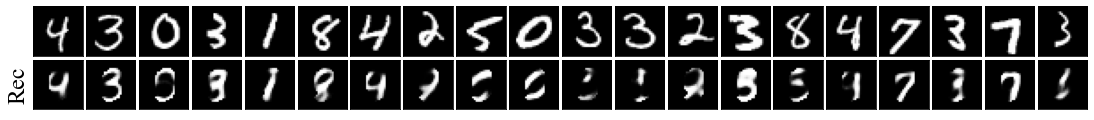

In [19]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], x_rec[0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

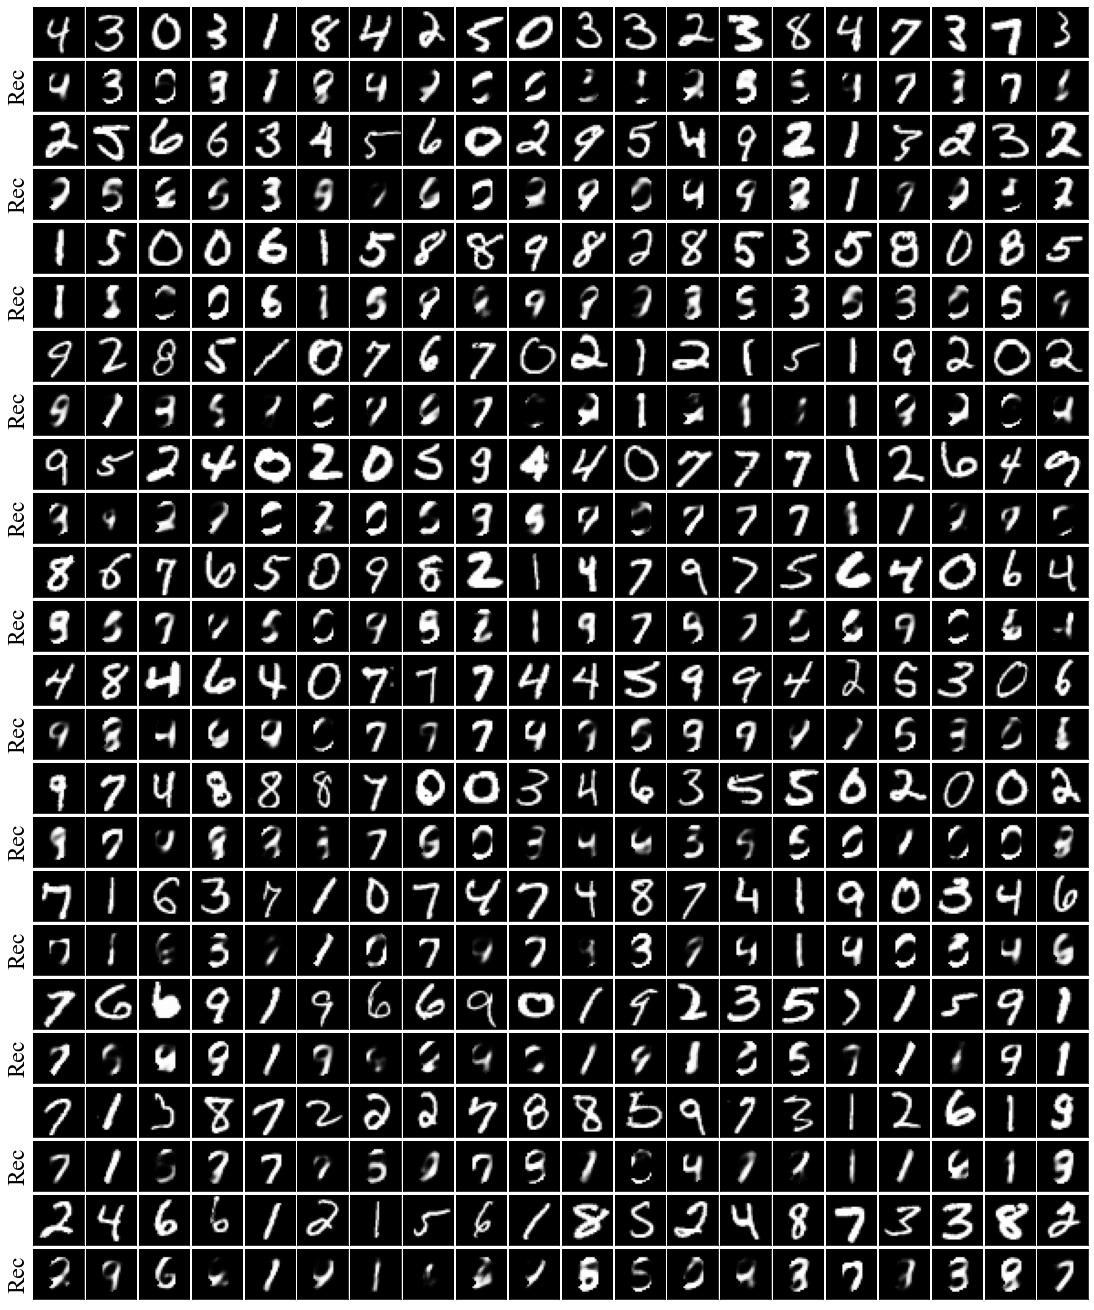

In [20]:
ncols = min(len(x_rec[0]), 20)
nrows = 2 * int(np.floor(len(x_rec[0]) / 20))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 1.5*nrows/2))
for i, aux in enumerate(zip(data[0], x_rec[0])):
    if i >= nrows / 2 * 20:
        break
    for j, im in enumerate(aux):
        ax[j+i//20*2, i%20].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j+i//20*2, i%20].set_xticks([])
        ax[j+i//20*2, i%20].set_yticks([])
    ax[1+i//20*2, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRecExtra.pdf', dpi=300)

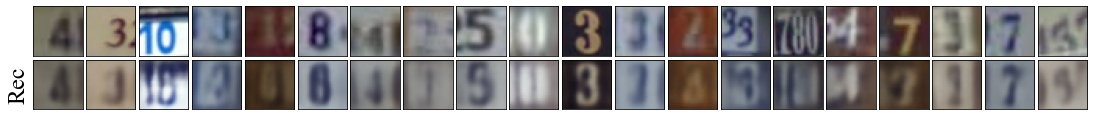

In [21]:
ncols = min(len(x_rec[1]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[1], x_rec[1])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().transpose(1, 2, 0), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'SVHNRec.pdf', dpi=300)

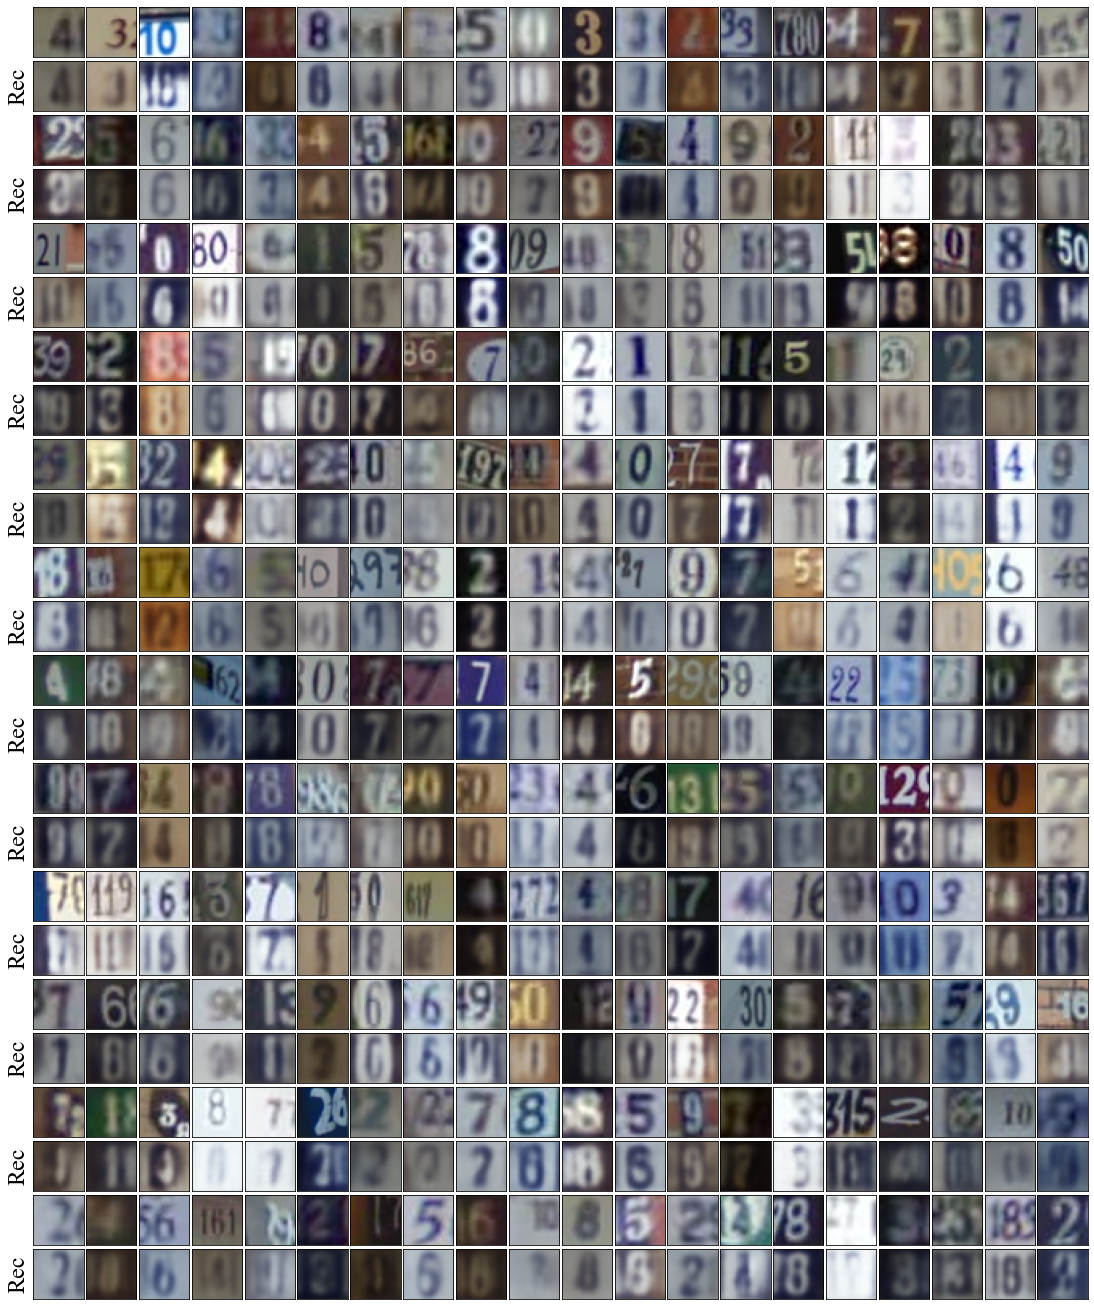

In [22]:
ncols = min(len(x_rec[1]), 20)
nrows = 2 * int(np.floor(len(x_rec[1]) / 20))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 1.5*nrows/2))
for i, aux in enumerate(zip(data[1], x_rec[1])):
    if i >= nrows / 2 * 20:
        break
    for j, im in enumerate(aux):
        ax[j+i//20*2, i%20].imshow(im.cpu().numpy().transpose(1, 2, 0), cmap='gray')
        ax[j+i//20*2, i%20].set_xticks([])
        ax[j+i//20*2, i%20].set_yticks([])
    ax[1+i//20*2, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'SVHNRecExtra.pdf', dpi=300)

### Cross Generation

#### MNIST -> SVHN

In [23]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].to(device, dtype=torch.float32), None])
        break

In [24]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
    x_rec = [x_rec[0].loc, x_rec[1].loc]
    
x_rec[1].shape, data[1].shape

(torch.Size([256, 3, 32, 32]), torch.Size([256, 3, 32, 32]))

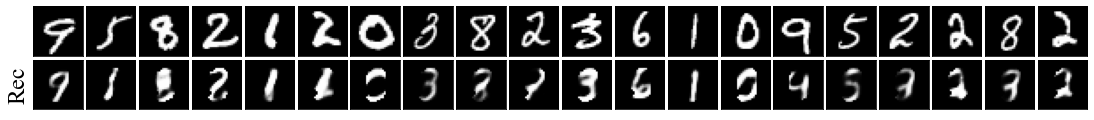

In [25]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], x_rec[0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

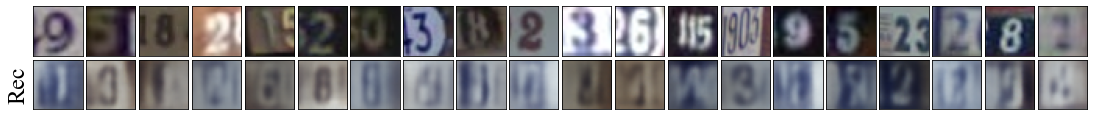

In [26]:
ncols = min(len(x_rec[1]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[1], x_rec[1])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().transpose(1, 2, 0), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'SVHNRec.pdf', dpi=300)

#### MNIST <- SVHN

In [27]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([None, data[1].to(device, dtype=torch.float32)])
        break

In [28]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
    x_rec = [x_rec[0].loc, x_rec[1].loc]
    
x_rec[1].shape, data[1].shape

(torch.Size([256, 3, 32, 32]), torch.Size([256, 3, 32, 32]))

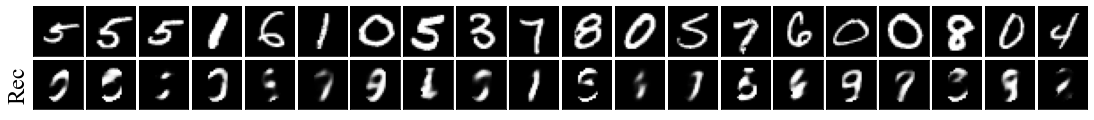

In [29]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], x_rec[0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

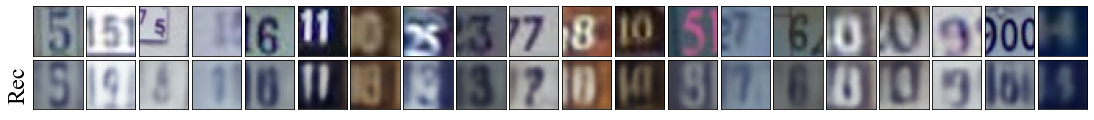

In [30]:
ncols = min(len(x_rec[1]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[1], x_rec[1])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().transpose(1, 2, 0), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'SVHNRec.pdf', dpi=300)

### Joint Generation

In [31]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([None, None])
        break

In [32]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
    x_rec = [x_rec[0].loc, x_rec[1].loc]
    
x_rec[1].shape, data[1].shape

(torch.Size([256, 3, 32, 32]), torch.Size([256, 3, 32, 32]))

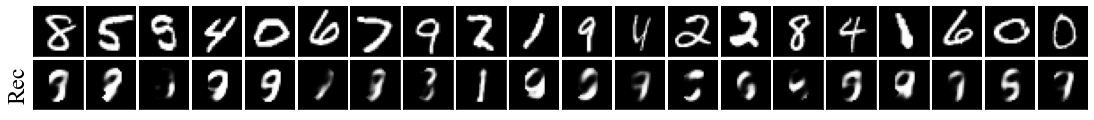

In [33]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], x_rec[0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

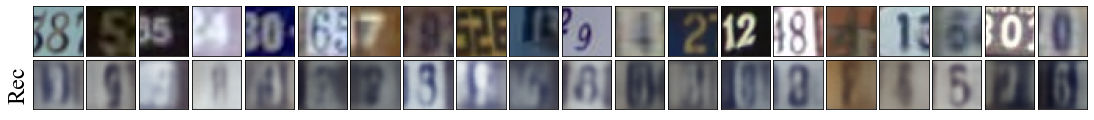

In [34]:
ncols = min(len(x_rec[1]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[1], x_rec[1])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().transpose(1, 2, 0), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'SVHNRec.pdf', dpi=300)